In [69]:
from PIL import Image

import sklearn
from sklearn import cluster
from sklearn import linear_model
from sklearn import neural_network
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import metrics
from sklearn import model_selection

import skimage
from skimage import color


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import os

import tools

import scipy
from scipy import spatial

import tools

In [70]:
# Processed Datapaths

TOMATO = True

processed_healthy = './Processed/Potato___healthy/'
processed_early_blight = './Processed/Potato___Early_blight/'
processed_late_blight = './Processed/Potato___Late_blight/'

if TOMATO == True:
    processed_healthy = './Processed/Tomato_healthy/'
    processed_early_blight = './Processed/Tomato_Early_blight/'
    processed_late_blight = './Processed/Tomato_Late_blight/'


healthy_images = tools.load_image_sample(processed_healthy, 400)
early_images = tools.load_image_sample(processed_early_blight, 200)
late_images = tools.load_image_sample(processed_late_blight, 200)

all_images = healthy_images + early_images + late_images

In [71]:
# Dataset functions

def dataset_non_zero_pixels(image_array: list[Image.Image]):
    whole = []
    for image in image_array:
        rgb_array = np.array(image)
        flat_rgb = tools.flatten(rgb_array)
        #flat_no_black = np.array([np.array(x) for x in flat_rgb if x.any() != 0])
        flat_no_black = flat_rgb[flat_rgb.any(axis=1)]
        whole.append(flat_no_black)
    returning = np.concatenate(whole)
    return returning

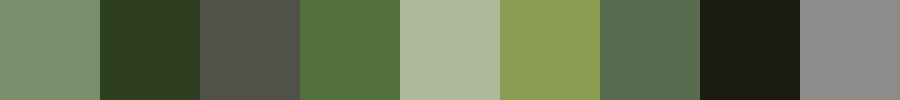

In [72]:
# COLOR CLASSIFICATION MODEL

training_pixels = color.rgb2lab(dataset_non_zero_pixels(all_images))

color_model = cluster.KMeans(9)

color_model.fit(training_pixels)

tools.create_palette_image(color.lab2rgb(color_model.cluster_centers_)*255)

In [73]:
healthy_counts = []

for image in healthy_images:
    lab_image = color.rgb2lab(tools.flatten(image))
    predicts = color_model.predict(lab_image)
    s = pd.Series(predicts).value_counts()
    a = s.sort_index().to_numpy()
    healthy_counts.append(a)

In [74]:

unhealthy_counts = []

for image in early_images:
    lab_image = color.rgb2lab(tools.flatten(image))
    predicts = color_model.predict(lab_image)
    s = pd.Series(predicts).value_counts()
    a = s.sort_index().to_numpy()
    unhealthy_counts.append(a)

for image in late_images:
    lab_image = color.rgb2lab(tools.flatten(image))
    predicts = color_model.predict(lab_image)
    s = pd.Series(predicts).value_counts()
    a = s.sort_index().to_numpy()
    unhealthy_counts.append(a)


In [75]:
healthy_frac = np.array([x / x.sum() for x in healthy_counts if x.size == 9])
unhealthy_frac = np.array([x / x.sum() for x in unhealthy_counts if x.size == 9])

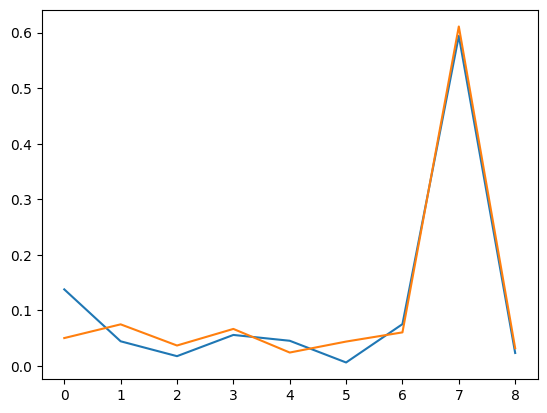

In [76]:
plt.plot(healthy_frac.mean(axis=0))
plt.plot(unhealthy_frac.mean(axis=0))

In [77]:
def matrix(model, dataset, actual):
    predictions = model.predict(dataset)
    return metrics.confusion_matrix(actual, predictions)

In [78]:
# DISEASE CLASSIFICATION MODEL

healthy_classifications = ["healthy" for h in healthy_frac]

unhealthy_classification = ["unhealthy" for h in unhealthy_frac]

d = np.concatenate([healthy_frac, unhealthy_frac])

c = np.concatenate([healthy_classifications, unhealthy_classification])

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(d, c, test_size=0.25)

In [79]:

LR = linear_model.LogisticRegression()

LR.fit(X_train, Y_train)

matrix(LR, X_test, Y_test)

array([[87, 13],
       [19, 67]])

In [80]:
NN = neural_network.MLPClassifier([100])
NN.fit(X_train, Y_train)

matrix(NN, X_test, Y_test)

/Users/jp/segmentation/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([[89, 11],
       [15, 71]])

In [81]:
KN = neighbors.KNeighborsClassifier()
KN.fit(X_train, Y_train)

matrix(KN, X_test, Y_test)

array([[96,  4],
       [10, 76]])